# Segmentation
This notebook uses:

* MONAI
* PyTorch Lightning

## 1. Packages and data loading

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
import csv

import torch
import pytorch_lightning as pl

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    Spacingd, ToTensord, DataStatsd, ToDeviced, \
    EnsureChannelFirstd, ScaleIntensityd, RandCropByPosNegLabeld, \
    CenterSpatialCropd

from monai.data import list_data_collate
from monai.data import decollate_batch
from monai.networks.layers import Norm
from monai.utils import InterpolateMode, UpsampleMode

from monai.visualize import img2tensorboard
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference

from torchsummary import summary
monai.config.print_config()

import random
import torchvision

import sys
import nibabel 
nibabel.imageglobals.logger.setLevel(40)
print(sys.path)
print(sys.executable)

MONAI version: 1.0.1
Numpy version: 1.23.4
Pytorch version: 1.13.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /home1/jz729/anaconda3/envs/sri_conv/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.22.0
Pillow version: 9.0.1
Tensorboard version: 2.11.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1
tqdm version: 4.61.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#

## 2. Verify System Setup

Check torch and CUDA on the system.

In [2]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))

CUDA available:  True
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000
GPU 2: Quadro RTX 8000


## Load sri conv

torch.Size([2, 3, 4]) torch.Size([1, 1, 4, 49])


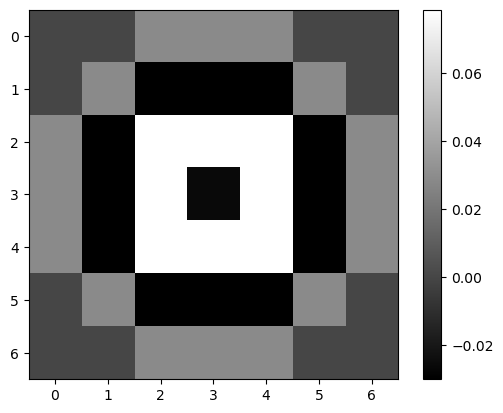

In [3]:
from SRI_Conv import SRI_Conv2d

conv = SRI_Conv2d(3, 2, 7, 1, 1, force_circular=True, gaussian_smooth_kernel=False, train_gaussian_sigma=True)
# print(conv.weight_index_mat)
# print(conv.sigmas.shape)
print(conv.weight.shape, conv.weight_index_mat.shape)
weight = conv._make_weight_matrix(conv.weight)
# print(weight, conv.ri_k)
plt.imshow(weight[0, 0, :, :].detach().numpy(), cmap='gray')
plt.colorbar()

## 3. Set the project path

In [4]:
EXP_NAME = 'segm_lightning_retina'
ROOT_PATH = r'/data16/private/jz729/project/sri_conv/notebooks_isbi'
EXP_PATH = os.path.join(ROOT_PATH,EXP_NAME.lower())

# Create the study directory structure
if not os.path.exists(EXP_PATH):
    print('Creating experiment directory: {}'.format(EXP_PATH))
    os.mkdir(EXP_PATH)

print('Using experiment directory: {}'.format(EXP_PATH))

Using experiment directory: /data16/private/jz729/project/sri_conv/notebooks_isbi/segm_lightning_retina


In [5]:
DATA_PATH = r'../data/retinal_dataset/DRIVE'
if not os.path.exists(DATA_PATH):
    DATA_PATH = r'/data16/private/jz729/project/sri_conv/data/retinal_dataset/DRIVE'
    sys.path.append(ROOT_PATH)

print(DATA_PATH)

../data/retinal_dataset/DRIVE


## 4. Load the data

In [6]:
def format_number(number):
    if 1 <= number <= 9:
        return f"0{number}"
    else:
        return str(number)

In [7]:
# create training dict
input_data_dict = list()
for i in range(21,41):
    mydict = {}
    mydict['SUBJECT_ID'] = str(i)
    mydict['INPUT'] = '{}/nii/train_data/{}_training.nii'.format(DATA_PATH, format_number(i))
    mydict['LABEL'] = '{}/nii/train_label/{}_manual1.nii'.format(DATA_PATH, format_number(i))
    input_data_dict.append(mydict)

print('Number of training files: ', len(input_data_dict))
print(input_data_dict[0:2])

if os.path.exists(input_data_dict[0]['INPUT']):
    print('image exists')
if os.path.exists(input_data_dict[0]['LABEL']):
    print('label exists')

Number of training files:  20
[{'SUBJECT_ID': '21', 'INPUT': '../data/retinal_dataset/DRIVE/nii/train_data/21_training.nii', 'LABEL': '../data/retinal_dataset/DRIVE/nii/train_label/21_manual1.nii'}, {'SUBJECT_ID': '22', 'INPUT': '../data/retinal_dataset/DRIVE/nii/train_data/22_training.nii', 'LABEL': '../data/retinal_dataset/DRIVE/nii/train_label/22_manual1.nii'}]
image exists
label exists


In [8]:
# create testing dict
hold_data_dict = list()
for i in range(1,21):
    mydict = {}
    mydict['SUBJECT_ID'] = str(i)
    mydict['INPUT'] = '{}/nii/test_data/{}_test.nii'.format(DATA_PATH, format_number(i))
    mydict['LABEL'] = '{}/nii/test_label/{}_manual1.nii'.format(DATA_PATH, format_number(i))
    hold_data_dict.append(mydict)

print('Number of testing files: ', len(hold_data_dict))
print(hold_data_dict[0:2])

if os.path.exists(hold_data_dict[0]['INPUT']):
    print('image exists')
if os.path.exists(hold_data_dict[0]['LABEL']):
    print('label exists')

Number of testing files:  20
[{'SUBJECT_ID': '1', 'INPUT': '../data/retinal_dataset/DRIVE/nii/test_data/01_test.nii', 'LABEL': '../data/retinal_dataset/DRIVE/nii/test_label/01_manual1.nii'}, {'SUBJECT_ID': '2', 'INPUT': '../data/retinal_dataset/DRIVE/nii/test_data/02_test.nii', 'LABEL': '../data/retinal_dataset/DRIVE/nii/test_label/02_manual1.nii'}]
image exists
label exists


In [9]:
num_val = 4
train_data_dict = input_data_dict
val_data_dict, _ = hold_data_dict[-num_val:], hold_data_dict[:-num_val]
test_data_dict = hold_data_dict
print('Number of training files: ', len(train_data_dict))
print('Number of validation files: ', len(val_data_dict))
print('Number of testing files: ', len(test_data_dict))

Number of training files:  20
Number of validation files:  4
Number of testing files:  20


## 5. Setup input transformations

In [10]:
class PermuteImaged(object):
    def __init__(self, keys):
        self.keys = keys
        pass

    def __call__(self, x):
        # (1, H, W, 3)
        for keys in self.keys:
            x[keys] = x[keys][0]
            x[keys] = np.transpose(x[keys], (2, 0, 1))
        # print('PermuteImaged: ',x[keys].shape)
        return x

In [11]:
class LambdaTransformd(object):
    def __init__(self, keys, transform, prob):
        self.keys = keys
        self.transform = transform
        self.prob = prob
        pass

    def __call__(self, x):
        # (1, H, W, 3)
        for keys in self.keys:
#             print('Before: ',x[keys].shape)
            if self.prob > random.random():
                x[keys] = self.transform(x[keys])
#             print('After: ',x[keys].shape)
        return x

In [12]:
# Set transforms 

PATCH_SIZE = [256, 256]
KEYS = ['INPUT', 'LABEL']

train_transforms = Compose([
    LoadImaged(keys=KEYS, reader='NibabelReader', as_closest_canonical=True),
    EnsureChannelFirstd(keys=KEYS), 
    PermuteImaged(keys=['INPUT']),
    ScaleIntensityd(keys=KEYS),
    # add data augmentation
#     monai.transforms.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=0),
#     monai.transforms.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=1),
#     monai.transforms.RandRotated(keys=KEYS, range_x=np.deg2rad(180), prob=0.5, 
#                                  mode=['nearest','nearest'], padding_mode=['zeros','zeros']),
#     monai.transforms.RandGaussianSmoothd(keys=['INPUT'], sigma_x=(2.5, 7.5), sigma_y=(2.5, 7.5), prob=0.5),
#     LambdaTransformd(keys=['INPUT'], 
#                      transform=torchvision.transforms.ColorJitter(
#                          brightness=0.2, contrast=0.1, #saturation=0.1,hue=0.1,
#                      ),
#                      prob=0.5
#                 ),
    RandCropByPosNegLabeld(keys=KEYS, label_key="LABEL", spatial_size=PATCH_SIZE, pos=1, neg=1, num_samples=8),
    ToTensord(keys=KEYS) 
])

val_transforms = Compose([
    LoadImaged(keys=KEYS, reader='NibabelReader', as_closest_canonical=True),
    EnsureChannelFirstd(keys=KEYS), 
    PermuteImaged(keys=['INPUT']),
    ScaleIntensityd(keys=KEYS),
#     monai.transforms.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=0),
#     monai.transforms.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=1),
#     monai.transforms.RandRotated(keys=KEYS, range_x=np.deg2rad(180), prob=1.0, 
#                                  mode=['nearest','nearest'], padding_mode=['zeros','zeros']),
#     monai.transforms.RandGaussianSmoothd(keys=KEYS, prob=1.0),
    ToTensord(keys=KEYS) 
])


test_transforms = Compose([
    LoadImaged(keys=KEYS, reader='NibabelReader', as_closest_canonical=True),
    EnsureChannelFirstd(keys=KEYS), 
    PermuteImaged(keys=['INPUT']),
    ScaleIntensityd(keys=KEYS),
    CenterSpatialCropd(keys=KEYS, roi_size=[512, 512]),
    ToTensord(keys=KEYS) 
])

# LambdaTransformd(keys=['INPUT'], 
#              transform=torchvision.transforms.RandomResizedCrop(size=PATCH_SIZE,
#                                                                 scale=(0.25, 1.0),),
#              prob=1.
#             ),

## 6. Check input data

dict_keys(['SUBJECT_ID', 'INPUT', 'LABEL', 'INPUT_meta_dict', 'LABEL_meta_dict'])
input shape: (16, 3, 256, 256)
image shape: (3, 256, 256), label shape: (256, 256)


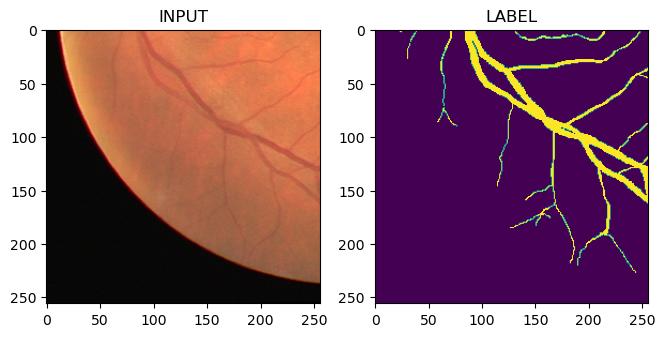

image shape: (3, 256, 256), label shape: (256, 256)


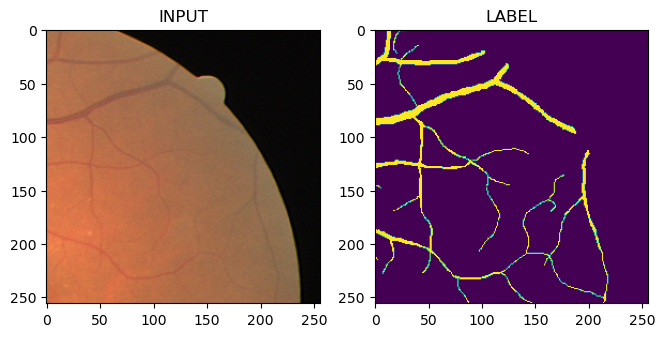

image shape: (3, 256, 256), label shape: (256, 256)


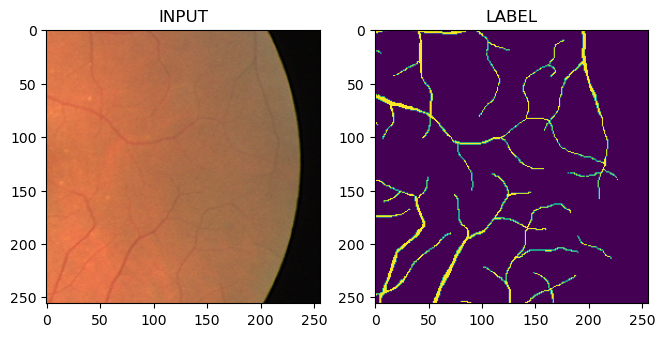

image shape: (3, 256, 256), label shape: (256, 256)


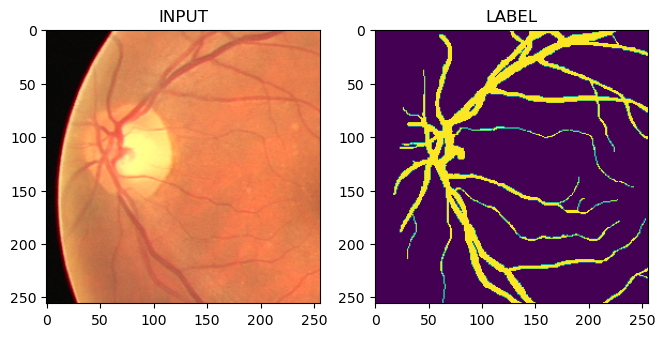

image shape: (3, 256, 256), label shape: (256, 256)


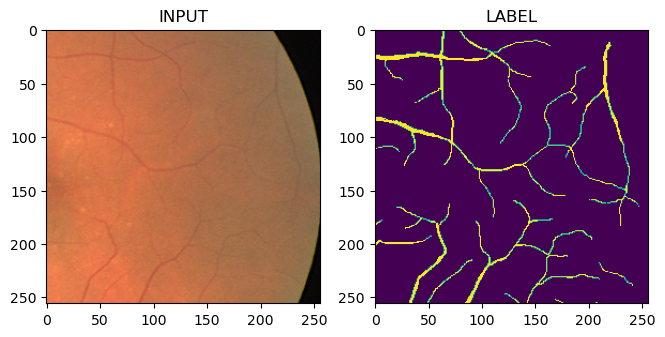

image shape: (3, 256, 256), label shape: (256, 256)


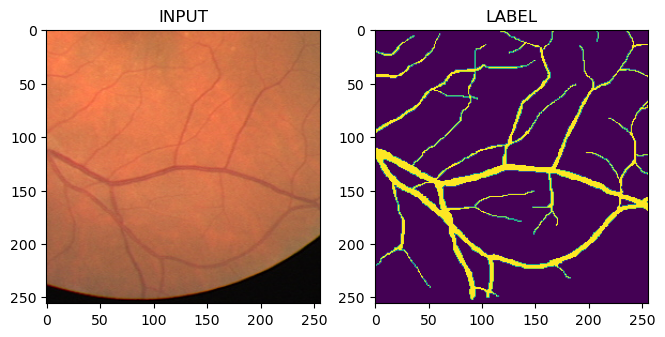

image shape: (3, 256, 256), label shape: (256, 256)


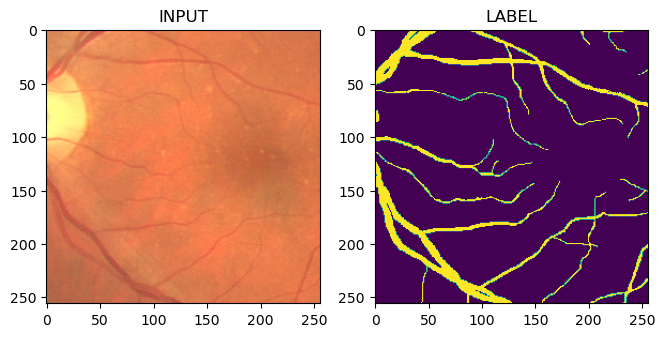

image shape: (3, 256, 256), label shape: (256, 256)


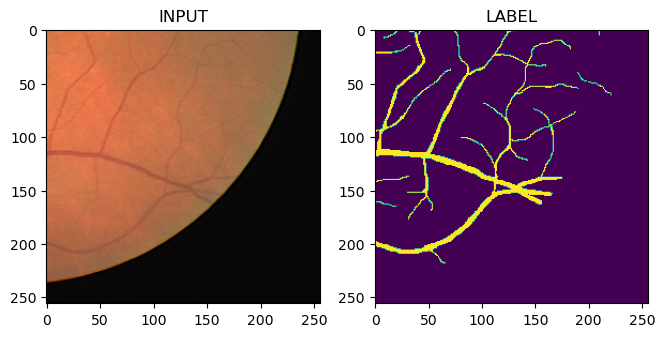

image shape: (3, 256, 256), label shape: (256, 256)


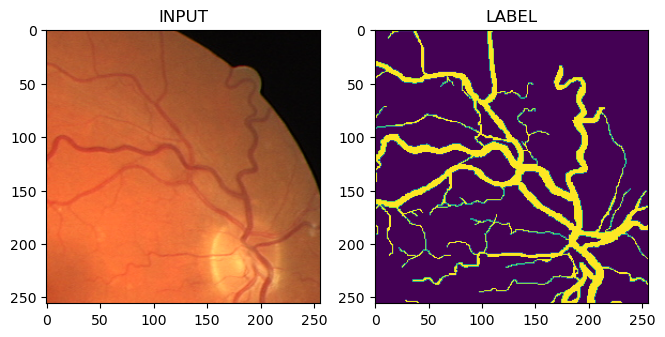

image shape: (3, 256, 256), label shape: (256, 256)


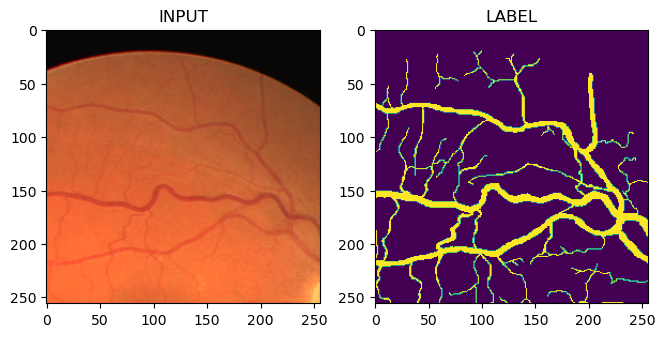

In [13]:
check_ds = monai.data.Dataset(data=train_data_dict[:2], transform=train_transforms)

check_loader = monai.data.DataLoader(check_ds, batch_size=3, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data.keys())
print('input shape:', check_data['INPUT'].shape)

num_display = 10
if check_data['INPUT'].shape[0] < num_display:
    num_display = check_data['INPUT'].shape[0]

for i in range(num_display):
    image, label = (check_data['INPUT'][i], check_data['LABEL'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))

    # slice_num = image.shape[2]//2
    
    plt.figure('check', (12, 4))
    
    plt.subplot(1, 3, 1)
    plt.title('INPUT')
    plt.imshow(np.transpose(image, (1,2,0)))

    plt.subplot(1, 3, 2)
    plt.title('LABEL')
    plt.imshow(label[:,:])
  
    plt.show()

del check_ds, check_loader, check_data

dict_keys(['SUBJECT_ID', 'INPUT', 'LABEL', 'INPUT_meta_dict', 'LABEL_meta_dict'])
input shape: (2, 3, 512, 512)
image shape: (3, 512, 512), label shape: (512, 512)


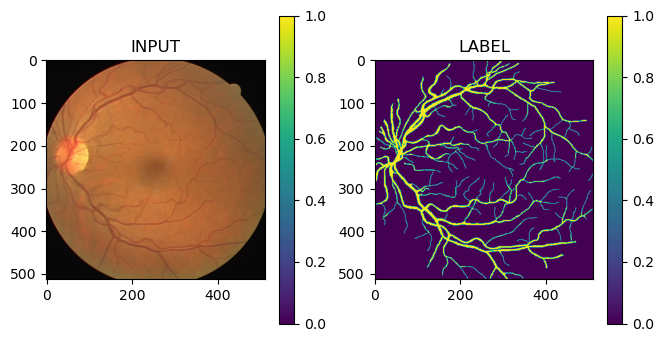

image shape: (3, 512, 512), label shape: (512, 512)


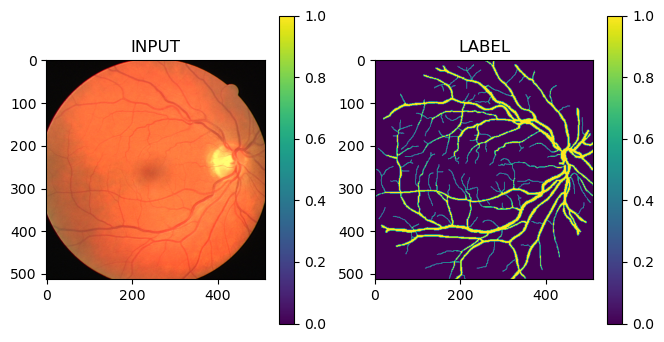

In [14]:
# check_ds = monai.data.Dataset(data=train_data_dict[:2], transform=train_transforms)
# check_ds = monai.data.Dataset(data=val_data_dict[:2], transform=val_transforms)
check_ds = monai.data.Dataset(data=test_data_dict[:2], transform=test_transforms)

check_loader = monai.data.DataLoader(check_ds, batch_size=3, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data.keys())
print('input shape:', check_data['INPUT'].shape)

num_display = 10
if check_data['INPUT'].shape[0] < num_display:
    num_display = check_data['INPUT'].shape[0]

for i in range(num_display):
    image, label = (check_data['INPUT'][i], check_data['LABEL'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))

    # slice_num = image.shape[2]//2
    
    plt.figure('check', (12, 4))
    
    plt.subplot(1, 3, 1)
    plt.title('INPUT')
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title('LABEL')
    plt.imshow(label[:,:])
    plt.colorbar()
  
    plt.show()

del check_ds, check_loader, check_data

## 7. Create a Data Cache for Training and Validation Data

In [17]:
# Use CacheDataset for training
train_ds = monai.data.CacheDataset(
    data=train_data_dict, 
    transform=train_transforms, 
)
train_loader = monai.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, collate_fn=list_data_collate)

Loading dataset: 100%|███████████████████████████████████████████████████| 20/20 [00:00<00:00, 75.98it/s]


In [18]:
# Use CacheDataset for validation
val_ds = monai.data.CacheDataset(
    data=val_data_dict, 
    transform=val_transforms
)
val_loader = monai.data.DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

Loading dataset: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 65.16it/s]


In [19]:
# Use CacheDataset for testing
test_ds = monai.data.CacheDataset(
    data=test_data_dict, 
    transform=test_transforms
)

test_loader = monai.data.DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████████████████| 20/20 [00:00<00:00, 75.41it/s]


## 8. Build network

In [20]:
import monai_unet_reproduce as unet
from importlib import reload
reload(unet)

<module 'monai_unet_reproduce' from '/data16/private/jz729/project/sri_conv/notebooks_isbi/monai_unet_reproduce.py'>

In [33]:
class SegNet(pl.LightningModule):
    
    def __init__(self, dropout=0.3):
        
        super().__init__()
        
        self.dropout = dropout
        
        # with SRI 
        self.layers = 3
        self.model = unet.BasicUNet(
            spatial_dims=2, 
            in_channels=3, 
            out_channels=2, 
            features=(32, 32, 64, 128, 256, 32), # has to be len of 6
            norm=Norm.BATCH,
            dropout=self.dropout,
            upsample=UpsampleMode.NONTRAINABLE,
            # interp_mode=InterpolateMode.LINEAR,
            use_sri=True,
            force_circular=True,
            kernels=(9,) * (self.layers+1), # has to be len of layers+1
            layers=self.layers,
        )
        
        # without SRI
#         self.layers = 4
#         self.model = unet.BasicUNet(
#             spatial_dims=2, 
#             in_channels=3, 
#             out_channels=2, 
#             features=(32, 32, 64, 128, 256, 32), # has to be len of 6
#             norm=Norm.BATCH,
#             dropout=self.dropout,
#             kernels=(3,) * (self.layers+1), # has to be len of layers+1
#             layers=self.layers,
#         )
        
        self.loss_function = torch.nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        return self.model(x)
    
    def prepare_data(self):
        
        # set deterministic training for reproducibility
        monai.utils.misc.set_determinism(seed=42)
    
    def training_step(self, batch, batch_idx):
        
        images = batch["INPUT"]
        labels = batch["LABEL"]
                
        outputs = self.forward(images)
        
        loss = self.loss_function(outputs, torch.squeeze(labels, dim=1).long())
        
        if batch_idx<1 and self.current_epoch%50==0:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            frame_dim=-1,
                            writer=self.logger.experiment,
                            tag='Train/Input')
            img2tensorboard.plot_2d_or_3d_image(data=torch.argmax(outputs, dim=1, keepdim=True), 
                            step=self.current_epoch, 
                            frame_dim=-1,
                            writer=self.logger.experiment,
                            tag='Train/Output')        
            
        return {"loss": loss}

        
    def training_epoch_end(self, outputs):
        
        # Only add the graph at the first epoch
#         if self.current_epoch==1:
#             sample_input = torch.rand((1,3,256,256)).to(device)
#             self.logger.experiment.add_graph(
#                 self.model,
#                 [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    def validation_step(self, batch, batch_idx):
        
        images = batch["INPUT"]
        labels = batch["LABEL"]

        roi_size = PATCH_SIZE
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, torch.squeeze(labels, dim=1).long())

        # Calculate an evaluation metric
        one_hot_fn =  monai.transforms.AsDiscrete(to_onehot=2)
        argmax_fn = monai.transforms.AsDiscrete(argmax=True)

        metric = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

        for i in range(outputs.shape[0]):
            one_hot_output = one_hot_fn(argmax_fn(outputs[i]))            
            metric(y_pred=one_hot_output, y=one_hot_fn(labels[i]))
            
        val_dice = metric.aggregate()

        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            frame_dim=-1,
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=torch.argmax(outputs, dim=1, keepdim=True), 
                            step=self.current_epoch, 
                            frame_dim=-1,
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}

    def validation_epoch_end(self, outputs):
        
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()

        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss.item())
        self.log('val_dice', avg_dice.item())

    def configure_optimizers(self):
#         total_params = list(self.feature_extractor.parameters()) + \
#                        list(self.regression_layers.parameters()) + \
#                        list(self.coattention.parameters())
        opt = torch.optim.Adam(self.model.parameters(), lr=5e-4)
        scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=100, gamma=0.98),
                     'name': 'Learning Rate'}
        return [opt], [scheduler]
    

In [34]:
from torchinfo import summary
# from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SegNet(dropout=0.0).to(device)
summary(model, (1,3,256,256))
# summary(model, (3,256,256))

BasicUNet features: (32, 32, 64, 128, 32).
Migrate from MONAI BasicUNet with changeable kernel size and SRI compatibility.


Layer (type:depth-idx)                             Output Shape              Param #
SegNet                                             [1, 2, 256, 256]          --
├─BasicUNet: 1-1                                   [1, 2, 256, 256]          --
│    └─TwoConv: 2-1                                [1, 32, 256, 256]         --
│    │    └─Convolution: 3-1                       [1, 32, 256, 256]         576
│    │    └─Convolution: 3-2                       [1, 32, 256, 256]         5,216
│    └─Down: 2-2                                   [1, 32, 128, 128]         --
│    │    └─MaxPool2d: 3-3                         [1, 32, 128, 128]         --
│    │    └─TwoConv: 3-4                           [1, 32, 128, 128]         10,432
│    └─Down: 2-3                                   [1, 64, 64, 64]           --
│    │    └─MaxPool2d: 3-5                         [1, 32, 64, 64]           --
│    │    └─TwoConv: 3-6                           [1, 64, 64, 64]           31,104
│    └─Down: 2-4       

In [20]:
MODEL_NAME = 'BasicUNet_SRI_layer3_ks9_nodp_upsample_fc'
MODEL_PATH = os.path.join(EXP_PATH,'models',MODEL_NAME) # saved_model
print('MODEL_PATH={}'.format(MODEL_PATH))

MODEL_PATH=./segmentation_lightning_retina/models/BasicUNet_SRI_layer3_ks9_nodp_upsample_fc


In [21]:
model.model#.upcat_3
# model.model.conv_0.conv_0.conv

BasicUNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): SRI_Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), output_padding=(4, 4))
      (adn): ADN(
        (N): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): SRI_Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), output_padding=(4, 4))
      (adn): ADN(
        (N): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (down_1): Down(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): SRI_Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4)

## 9. Train the Model Using Lightning Training Loop

In [22]:
# Initialise the LightningModule
model = SegNet(dropout=0.0)

# Set up loggers and checkpoints
tb_logger = pl.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_PATH,'logs')
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_PATH),
    filename="SegNet-{epoch:04d}-{val_loss:.3f}",
    monitor='val_loss',
    save_last=True,
    save_top_k=2,
    mode='min'
)

# Check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_PATH,'last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_PATH,'last.ckpt')

# Initialise Lightning's trainer.
trainer = pl.Trainer(
    accelerator='gpu',
    devices=[1],
    max_epochs=6000, 
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
)

# Train
trainer.fit(model, train_loader, val_loader, ckpt_path=resume_checkpoint) 

GPU available: True (cuda), used: True
/home1/jz729/anaconda3/envs/sri_conv/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


BasicUNet features: (32, 32, 64, 128, 32).
Migrate from MONAI BasicUNet with changeable kernel size and SRI compatibility.


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./segmentation_lightning_retina/models/BasicUNet_SRI_layer3_ks9_nodp_upsample_fc/logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | BasicUNet        | 274 K 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
274 K     Trainable params
0         Non-trainable params
274 K     Total params
1.097     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home1/jz729/anaconda3/envs/sri_conv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 10. Testing and evaluation

In [23]:
RESULTS_PATH = os.path.join(EXP_PATH,'results',MODEL_NAME)

# Create the study directory structure
if not os.path.exists(RESULTS_PATH):
    print('Creating experiment directory: {}'.format(RESULTS_PATH))
    os.makedirs(RESULTS_PATH)
    
print('RESULTS_PATH={}'.format(RESULTS_PATH))

Creating experiment directory: ./segmentation_lightning_retina/results/BasicUNet_SRI_layer3_ks9_nodp_upsample_fc
RESULTS_PATH=./segmentation_lightning_retina/results/BasicUNet_SRI_layer3_ks9_nodp_upsample_fc


In [24]:
# Load 
model_path = os.path.join(MODEL_PATH,'last.ckpt')
# model_path = os.path.join(MODEL_PATH,'SegNet-epoch=1389-val_loss=0.097.ckpt')
print('Loading saved model from: {}'.format(model_path))

model = SegNet.load_from_checkpoint(model_path).eval()

Loading saved model from: ./segmentation_lightning_retina/models/BasicUNet_SRI_layer3_ks9_nodp_upsample_fc/last.ckpt
BasicUNet features: (32, 32, 64, 128, 32).
Migrate from MONAI BasicUNet with changeable kernel size and SRI compatibility.


In [ ]:
# first_name, first_weights = next(model.named_parameters())
# print(first_name)
# print(first_weights.shape)
# print(first_weights.is_cuda)
# first_weights[0,...]

## 11. Utils evaluation

In [25]:
from utils import run_inference_and_evaluate_2D

evaluation_results = list()

for rot_degree in range(0, 360, 10):
    print('Evaluating rotation degree {}...'.format(rot_degree))
    
    for i, test_data in enumerate(test_loader):
        print('Evaluating input {}...'.format(i))
        df_eval = run_inference_and_evaluate_2D(
            model=model, 
            batch=test_data, 
            roi_size=(512, 512), 
            # plot_images=True, 
            # save_output_path=os.path.join(EXP_PATH,'results'),
            device=torch.device("cuda:2"),
            rot_degree=rot_degree
        )
        evaluation_results.append(df_eval)
#         break
        
df_results = pd.concat(evaluation_results).reset_index(drop=True)
df_results['EXPERIMENT_ID'] = EXP_NAME
df_results.describe()

Evaluating rotation degree 0...
Evaluating input 0...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 1...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 2...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 3...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 4...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 5...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 6...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 7...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 8...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 9...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 10...
pred shape: (2, 512, 512), label sh

Evaluating input 8...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 9...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 10...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 11...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 12...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 13...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 14...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 15...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 16...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 17...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 18...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim:

Evaluating input 17...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 18...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 19...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating rotation degree 90...
Evaluating input 0...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 1...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 2...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 3...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 4...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 5...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 6...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 7...
pred shape: (2, 512, 512), label

Evaluating input 5...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 6...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 7...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 8...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 9...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 10...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 11...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 12...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 13...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 14...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 15...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C

Evaluating input 14...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 15...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 16...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 17...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 18...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 19...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating rotation degree 180...
Evaluating input 0...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 1...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 2...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 3...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 4...
pred shape: (2, 512, 512), l

Evaluating input 2...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 3...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 4...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 5...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 6...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 7...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 8...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 9...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 10...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 11...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 12...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,

Evaluating input 11...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 12...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 13...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 14...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 15...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 16...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 17...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 18...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 19...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating rotation degree 270...
Evaluating input 0...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 1...
pred shape: (2, 512, 512)

Evaluating rotation degree 310...
Evaluating input 0...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 1...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 2...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 3...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 4...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 5...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 6...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 7...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 8...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 9...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 10...
pred shape: (2, 512, 512), label 

Evaluating input 8...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 9...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 10...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 11...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 12...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 13...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 14...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 15...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 16...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 17...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim: (C,H,W).
Evaluating input 18...
pred shape: (2, 512, 512), label shape: (1, 512, 512); Dim:

,ROT,ACC,SEN,SPE,IOU,DICE,AUC,INFERENCE_TIME
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,175.000000,0.952076,0.732157,0.979220,0.621514,0.765340,0.957749,0.094657
std,103.955163,0.007212,0.088467,0.007337,0.050671,0.039936,0.016574,0.091707
min,0.000000,0.928440,0.525821,0.963460,0.487431,0.655400,0.901217,0.046317
25%,87.500000,0.950436,0.666653,0.973828,0.609366,0.757275,0.953542,0.056648
50%,175.000000,0.953417,0.761219,0.978110,0.631771,0.774338,0.960856,0.115134
75%,262.500000,0.955853,0.788692,0.986531,0.647042,0.785702,0.966853,0.119719
max,350.000000,0.963470,0.883723,0.993767,0.714677,0.833600,0.979672,2.400469


In [26]:
CKPT_NAME = 'last_ckpt'
CSV_PATH = os.path.join(RESULTS_PATH, '{}_results.csv'.format(CKPT_NAME))

print('CSV_PATH={}'.format(CSV_PATH))
df_results.to_csv(CSV_PATH, index=False)

CSV_PATH=./segmentation_lightning_retina/results/BasicUNet_SRI_layer3_ks9_nodp_upsample_fc/last_ckpt_results.csv


In [27]:
df_results_read = pd.read_csv(CSV_PATH, sep=',')
df_results_read.describe()

,ROT,ACC,SEN,SPE,IOU,DICE,AUC,INFERENCE_TIME,SUBJECT_ID
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.00000
mean,175.000000,0.952076,0.732157,0.979220,0.621514,0.765340,0.957749,0.094657,10.50000
std,103.955163,0.007212,0.088467,0.007337,0.050671,0.039936,0.016574,0.091707,5.77029
min,0.000000,0.928440,0.525821,0.963460,0.487431,0.655400,0.901217,0.046317,1.00000
25%,87.500000,0.950436,0.666653,0.973828,0.609366,0.757275,0.953542,0.056648,5.75000
50%,175.000000,0.953417,0.761219,0.978110,0.631771,0.774338,0.960856,0.115134,10.50000
75%,262.500000,0.955853,0.788692,0.986531,0.647042,0.785702,0.966853,0.119719,15.25000
max,350.000000,0.963470,0.883723,0.993767,0.714677,0.833600,0.979672,2.400469,20.00000


df_results exists!


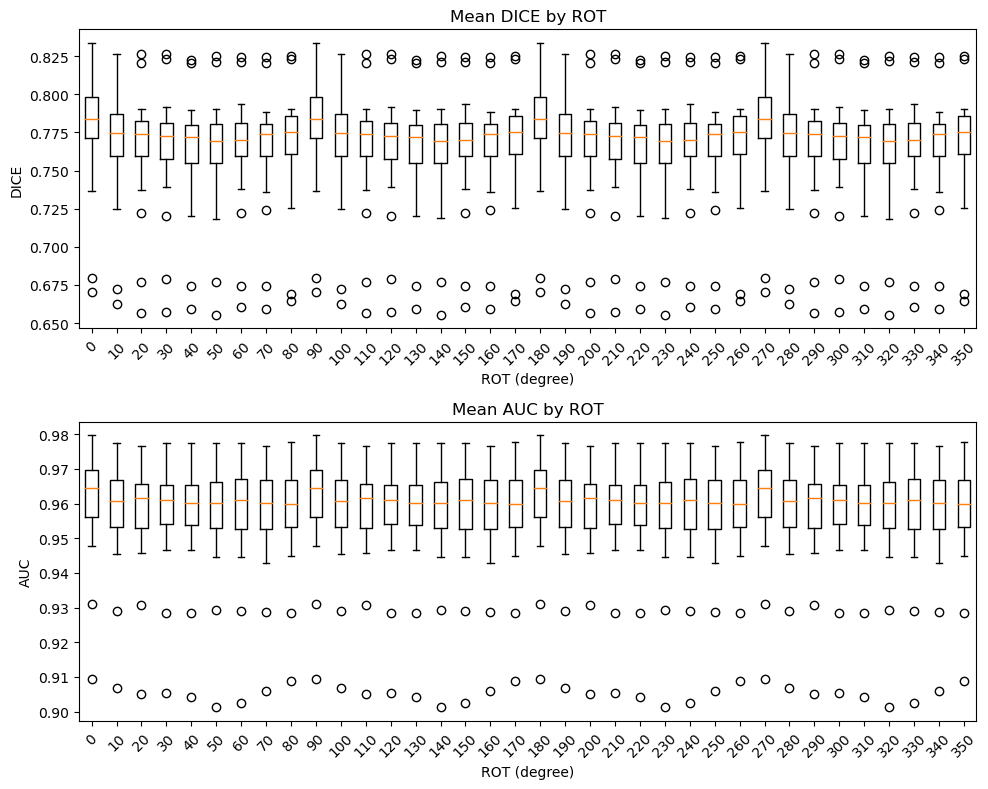

In [28]:
if 'df_results' in vars ().keys():
    print('df_results exists!')
else:
    print('df_results does not exist!')
    df_results = df_results_read

# plot the curve
plt.figure(figsize=(10, 8))

result = df_results.groupby('ROT')['DICE'].agg(['mean', 'std']).reset_index()
plt.subplot(2, 1, 1)
plt.title('INPUT')
plt.boxplot([df_results[df_results['ROT'] == rot]['DICE'] for rot in result['ROT']], labels=result['ROT'])
plt.xlabel('ROT (degree)')
plt.ylabel('DICE')
plt.title('Mean DICE by ROT')
plt.xticks(rotation=45)

result = df_results.groupby('ROT')['AUC'].agg(['mean', 'std']).reset_index()
plt.subplot(2, 1, 2)
plt.title('INPUT')
plt.boxplot([df_results[df_results['ROT'] == rot]['AUC'] for rot in result['ROT']], labels=result['ROT'])
plt.xlabel('ROT (degree)')
plt.ylabel('AUC')
plt.title('Mean AUC by ROT')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [29]:
metric_list = ['DICE', 'AUC']

for i, meritc in enumerate(metric_list):
    print('Evaluating metric: {}...'.format(meritc))
    
    result = df_results.groupby('ROT')[meritc].agg(['mean', 'std']).reset_index()
    
    print('Mean {} (all angles): {}'.format(meritc, result['mean'].mean()))
    print('Mean {} (rot=0): {}'.format(meritc, result[result['ROT'] == 0]['mean'].item()))
    print('Mean {} (rot=90): {}'.format(meritc, result[result['ROT'] == 90]['mean'].item()))
    print('STD of Mean {} (all angles): {}'.format(meritc, result['mean'].std()))
    print()

# result

Evaluating metric: DICE...
Mean DICE (all angles): 0.7653397140996183
Mean DICE (rot=0): 0.7757181053502336
Mean DICE (rot=90): 0.7757181053502336
STD of Mean DICE (all angles): 0.0038703503286367227

Evaluating metric: AUC...
Mean AUC (all angles): 0.9577487423039304
Mean AUC (rot=0): 0.9604552728057756
Mean AUC (rot=90): 0.9604552718350998
STD of Mean AUC (all angles): 0.0009875967440173834



## 12. Visualization

In [ ]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# load image
image_list = []
for i, test_data in enumerate(test_loader):
    x = test_data['INPUT'].to(device) # cpu() / to(device)
    image_list.append(x)
    
    if i==1:
        break

In [ ]:
from utils import vis_feat

layer_list = ['conv_0', 'down_1', 'upcat_1']
ks_list = [7, 7, 7]
for k, tar_layer in enumerate(layer_list):
    print('Evaluating target layer {} (index:{} and kernel size:{})...'.format(tar_layer, k, ks_list[k]))
    vis_feat(nrow=1, ncol=len(image_list), 
             vis_model=model.model.to(device), 
             target_layer=tar_layer, # conv_0 / down_1 / down_2 / down_3 / down_4
             input_list=image_list, 
             feat_idx=1, 
             test_dataset=None, 
             img_idx=None, 
             save_path=None, 
             vis_ouput=False,
             verbosity=False,
#              num_feat=8
    )

In [ ]:
model.model